## Overview The Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray

import os
print(os.listdir("./archive"))

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

['.DS_Store', 'archive', 'one-indexed-files-notrash_test.txt', 'zero-indexed-files.txt', 'one-indexed-files-notrash_val.txt', 'garbage_classification', 'one-indexed-files-notrash_train.txt', 'one-indexed-files.txt']


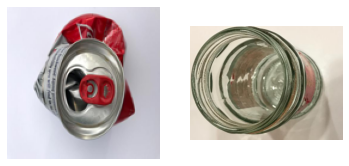

In [2]:
filepath = "./archive/garbage_classification/images/metal/metal100.jpg"
filepath2 = "./archive/garbage_classification/images/glass/glass21.jpg"

img1 = Image.open(filepath)
img2 = Image.open(filepath2)
img_size = 128
plt.subplot(1, 2, 1)
img1 = img1.resize((img_size, img_size))
plt.imshow(img1)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis("off")
plt.show()

In [3]:
# cardboard = "./archive/garbage_classification/images/cardboard/"
glass= "./archive/garbage_classification/images/glass/"
#metal= "./archive/garbage_classification/images/metal/"
paper= "./archive/garbage_classification/images/paper/"
plastic=  "./archive/garbage_classification/images/plastic/"
# trash=  "./archive/garbage_classification/images/trash/"

dict = {}
#dict[0] = 'cardboard'
dict[0] = 'glass'
dict[1] = 'plastic'
dict[2] = 'paper'

In [16]:
minh, minv = 100000,100000

for p in range(0,328):
    s = ''
    if p<10:
        s += '00'
    elif p < 100:
        s += '0'
    pic = Image.open(metal+s+str(p)+".jpg")
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
for u in range(0,401):
    s = ''
    if u<10:
        s += '00'
    elif u < 100:
        s += '0'
    pic = Image.open(glass+s+str(u)+".jpg")
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
print(minh)
print(minv)

512
384


In [4]:
train_images = []
# train_cardboard = []
# for p in range(1,404):
#     image = Image.open(cardboard+"cardboard"+str(p)+".jpg")
#     image = image.resize((img_size, img_size))
#     image = image.convert(mode="L")
#     train_images.append(image)

for p in range(1,869):
    image = Image.open(glass+"glass"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    image = image.convert(mode="L")
    train_images.append(image)

for p in range(1,869):
    image = Image.open(plastic+"plastic"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    image = image.convert(mode="L")
    train_images.append(image)

for p in range(1,869):
    image = Image.open(paper+"paper"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    image = image.convert(mode="L")
    train_images.append(image)

In [5]:
X = np.empty((868+868+868, img_size* img_size))
index = 0
for pl in train_images:
    # Normalize pixel values
    pixels = asarray(pl)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    X[index] = pixels.reshape(img_size * img_size)
    index += 1
# for ul in train_glass:
#     X[index] = np.array(ul).reshape(img_size* img_size)
#     index += 1    
#c = np.zeros(403)
g = np.zeros(868)
m = np.ones(868)
#m.fill(2)
p = np.empty(868)
p.fill(2)
y = np.concatenate((g, m, p), axis=0).reshape(X.shape[0], 1)

print(X[0])
print(y[0])
print("x shape: ", X.shape)
print("y shape: ", y.shape)

[0.74117649 0.74509805 0.74901962 ... 0.84705883 0.84313726 0.84313726]
[0.]
x shape:  (2604, 16384)
y shape:  (2604, 1)


In [6]:
def featureNormalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    mean= np.mean(X, axis=0)
    std= np.std(X, axis=0)
    
    X_norm =(X-mean)/std
    
    return X_norm , mean , std

In [11]:

# X , X_mean, X_std = featureNormalization(X)
# X = X - X_mean

y = y.ravel()

# extract train sub-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nsamples,nrgb = X_train.shape
X_train = X_train.reshape((nsamples,nrgb))

nsamples, nrgb = X_test.shape
X_test = X_test.reshape((nsamples,nrgb))

# st_x = StandardScaler()    
# X_train = st_x.fit_transform(X_train)    
# X_test = st_x.transform(X_test) 
  
# X_train.mean(axis=0)
# X_train.std(axis=0)
# extract cross validation and test sub-sets
#X_test, X_val, y_test, y_val = train_test_split(X_remain, y_remain, test_size=0.4, random_state=42)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

# print(f"X val flatten: {X_val.shape}")
# print(f"y val: {y_val.shape}")

# print(f"X test flatten: {X_test.shape}")
# print(f"y test: {y_test.shape}")

X train: (2083, 16384)
y train: (2083,)
X test: (521, 16384)
y test: (521,)


In [7]:
def confusion_matrixx(y_true, y_pred, labels=None, normalize=None, cmap="Blues", encoded_labels=True, plot=True):
    """
    Args:
        y_true (ndarray)
        y_pred (ndarray)
        labels (list)
        normalise (str) : {'all', None}
        cmap (maplotlib.pyplot.cmap)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        plot (bool): If False, plot will not appear for confusion matrix
    
    Return:
        conf_mat (tuple): TN, FP, FN, TP
    """
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    if normalize not in ('all', None):
        raise ValueError("normalize must be one of {'all', None}")

    conf_labels = None if encoded_labels else labels
    fmt = 'g' if normalize == None else '.2%'
                         
    conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize, labels=conf_labels)
    if plot:
        ax = sns.heatmap(conf_mat, cmap=cmap, square=True, cbar=False, annot=True, fmt=fmt)
        ax.set_title("Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        if labels != None:
            ax.set_yticklabels(labels)
            ax.set_xticklabels(labels)

    return conf_mat

def model_train(model, name, X_train, y_train, X_test, y_test):
    

    # fitting the object
    model.fit(X_train, y_train)
    
    # finding the predicted valued
    y_pred = model.predict(X_test)

    # determine test accuracy
    test_data_accuracy = accuracy_score(y_pred, y_test)

    # F1_score = 2 * (P * R)/(P + R)
    #   P : Precision
    #   R : Recall of the model
    #f1 = f1_score(y_test, y_pred, labels=index)

    #   >> Accuracy vs F1-score
    # Accuracy is used when the True Positives and True negatives are more important 
    # while F1-score is used when the False Negatives and False Positives are crucial

    print()
    print("---- Model Analysis ----")
    print("Accuracy (train) for %s: %0.1f%% " % (name, test_data_accuracy * 100))
    #print('F1 Score: ', f1 * 100, "%")
    
    print()
    
    print("---- Confusion Matrix ----")
    index = ('glass', 'plastic', 'paper')
    cm = confusion_matrix(y_test, y_pred)

    dataframe = pd.DataFrame(cm, index=index, columns=index)

    print(dataframe)

    # cm_df = pd.DataFrame(cm, index = ['CARDBOARD', 'GLASS', 'METAL'], columns=['CARDBOARD', 'GLASS', 'METAL'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    # fig, ax = plt.subplots(figsize=(8, 8))
    # ax.imshow(cm)
    # ax.grid(False)
    # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    # ax.set_ylim(1.5, -0.5)
    # for i in range(2):
    #     for j in range(2):
    #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    # plt.show()
    
    print()
    print("---- Classification Report ----")
    print( classification_report(y_test, model.predict(X_test)) )

def hyperparameters(model, params, X, y):
    print(">> Find hyperparameters for a model")

    model = GridSearchCV(model, params, scoring="accuracy")
    model.fit(X, y)
    print(" Best Params:", model.best_params_)

    return model.best_params_



def kfold(model, k, X_train, y_train):
    print(">> k-fold cross-validation")
    
    kf = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, y_train, scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

## Logistic Regression


---- Model Analysis ----
Accuracy (train) for L1: 84.0% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      152       23     10
plastic     14      144      7
paper       19       18    181


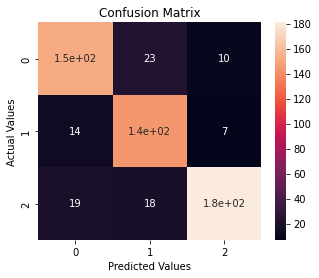


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       185
         1.0       0.78      0.87      0.82       165
         2.0       0.91      0.83      0.87       218

    accuracy                           0.84       568
   macro avg       0.84      0.84      0.84       568
weighted avg       0.84      0.84      0.84       568



In [16]:
# C=10
# classifiers = {
#     'Logistic Multinomial': LogisticRegression(multi_class='multinomial',
#                                       max_iter=2000),
#     'Logistic One-vs-Rest': LogisticRegression(multi_class='ovr',
#                                             max_iter=2000)
# }

# for index, (name, classifier) in enumerate(classifiers.items()):
#     model_train(classifier, name, X_train, y_train, X_test, y_test)


# Using multinomial logistic regression
model = LogisticRegression(max_iter=2000)
model_train(model,'L1', X_train, y_train, X_test, y_test)

# Hypertuned Params
# model_params = [{'multi_class': ['multinomial', 'ovr'], 'max_iter': [100, 400, 800]}]
# best_model_params = hyperparameters(model, model_params , X_train, y_train)

# model.set_params(**best_model_params)
# model_train(model, X_train, y_train, X_test, y_test)


# K-Fold Cross-Validation
# kfmodel = kfold(model, 5, X_train, y_train, X_test, y_test)
# model_train(kfmodel, X_train, y_train, X_test, y_test)



# hypertuned_model = LogisticRegression()

# model.fit(X_train, y_train)

# print(model.score(X_test, y_test))

# print('Predicted value is =', dict.get(int(model.predict([X_test[200]]))))

# print('Actual value from test data is = %s' % (dict.get(int(y_test[200]))))

# plt.matshow(train_images[200])

# print(dict.get(int(model.predict([X_test[200]]))))

# print(confusion_matrix(y_test, model.predict(X_test)))

# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
# svm_predictions = svm_model_linear.predict(X_test)

# print(dict.get(int(svm_model_linear.predict([X_test[200]]))))

# print(confusion_matrix(y_test, svm_model_linear.predict(X_test)))
  
# # model accuracy for X_test  
# print(svm_model_linear.score(X_test, y_test))

# knn_classifier = KNeighborsClassifier()
# knn_classifier.fit(X_train, y_train)
# knn_predictions = knn_classifier.predict(X_train)

# print(knn_classifier.score(X_test, y_test))

# print()
# print("""
# |-------------------------------------|
# |             Base Model              |
# |-------------------------------------|
# """)
# print()
# model_train(model, X_train, y_train, X_test, y_test)

## Neural Network

/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



---- Model Analysis ----
Accuracy (train) for NN: 33.8% 

---- Confusion Matrix ----
         glass  plastic  paper
glass        0        0    181
plastic      0        0    164
paper        0        0    176


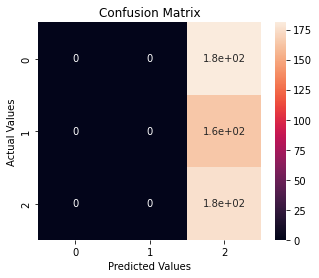


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       181
         1.0       0.00      0.00      0.00       164
         2.0       0.34      1.00      0.51       176

    accuracy                           0.34       521
   macro avg       0.11      0.33      0.17       521
weighted avg       0.11      0.34      0.17       521

>> Find hyperparameters for a model


/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eduardo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
model = MLPClassifier(max_iter=20000)
model2 = MLPClassifier()
model_train(model,'NN', X_train, y_train, X_test, y_test)

mlp_parameters = {
    'hidden_layer_sizes': [(2,),(4,),(6,),(8,)],
    'activation': ['logistic', 'tanh'],
    'solver': [ 'adam'],
    'max_iter': [10000, 20000],
}

hyper_mlp_parameters = hyperparameters(model, mlp_parameters , X_train, y_train)
model.set_params(**hyper_mlp_parameters)
model_train(model,'NN', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X, y)
model_train(kfmodel,'NN', X_train, y_train, X_test, y_test)


## Random Forest


---- Model Analysis ----
Accuracy (train) for RFC: 92.9% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      171        5      5
plastic      8      155      1
paper        8       10    158


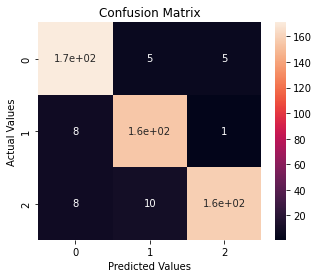


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       181
         1.0       0.91      0.95      0.93       164
         2.0       0.96      0.90      0.93       176

    accuracy                           0.93       521
   macro avg       0.93      0.93      0.93       521
weighted avg       0.93      0.93      0.93       521

>> Find hyperparameters for a model
 Best Params: {'criterion': 'entropy', 'max_features': 'sqrt'}

---- Model Analysis ----
Accuracy (train) for RFC: 93.1% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      165        9      7
plastic      4      159      1
paper        4       11    161


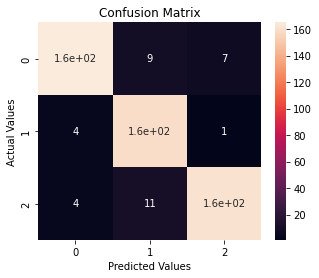


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       181
         1.0       0.89      0.97      0.93       164
         2.0       0.95      0.91      0.93       176

    accuracy                           0.93       521
   macro avg       0.93      0.93      0.93       521
weighted avg       0.93      0.93      0.93       521

>> k-fold cross-validation

---- Model Analysis ----
Accuracy (train) for RFC: 92.3% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      167        8      6
plastic      7      157      0
paper       10        9    157


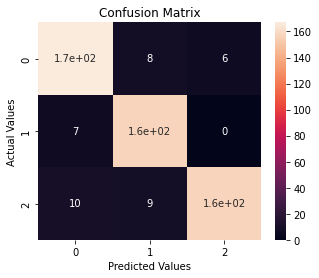


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       181
         1.0       0.90      0.96      0.93       164
         2.0       0.96      0.89      0.93       176

    accuracy                           0.92       521
   macro avg       0.92      0.92      0.92       521
weighted avg       0.92      0.92      0.92       521



In [9]:
model = RandomForestClassifier()

model_train(model, 'RFC', X_train, y_train, X_test, y_test)

rfc_parameters = { 
    'max_features': ['auto', 'sqrt'],
    'criterion' :['gini', 'entropy'],
}

hyper_rfc_parameters = hyperparameters(model, rfc_parameters , X_train, y_train)
model.set_params(**hyper_rfc_parameters)
model_train(model,'RFC', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X, y)
model_train(kfmodel,'RFC', X_train, y_train, X_test, y_test)

## Decision Tree


---- Model Analysis ----
Accuracy (train) for DecisionTree: 85.4% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      153       17     11
plastic     12      144      8
paper       15       13    148


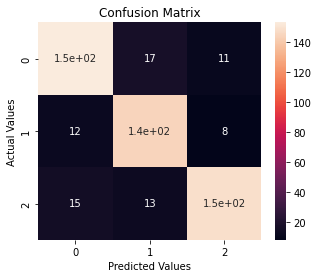


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       181
         1.0       0.83      0.88      0.85       164
         2.0       0.89      0.84      0.86       176

    accuracy                           0.85       521
   macro avg       0.85      0.85      0.85       521
weighted avg       0.86      0.85      0.85       521



In [21]:
model = DecisionTreeClassifier()

model_train(model, 'DecisionTree', X_train, y_train, X_test, y_test)

## Gaussian NB


---- Model Analysis ----
Accuracy (train) for GNB: 51.6% 

---- Confusion Matrix ----
         glass  plastic  paper
glass       69       83     29
plastic     23      125     16
paper       22       79     75


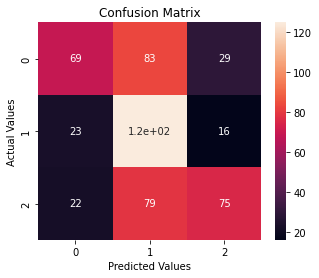


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.61      0.38      0.47       181
         1.0       0.44      0.76      0.55       164
         2.0       0.62      0.43      0.51       176

    accuracy                           0.52       521
   macro avg       0.56      0.52      0.51       521
weighted avg       0.56      0.52      0.51       521

>> Find hyperparameters for a model
 Best Params: {'var_smoothing': 0.0023101297000831605}

---- Model Analysis ----
Accuracy (train) for GNB: 51.4% 

---- Confusion Matrix ----
         glass  plastic  paper
glass       69       83     29
plastic     23      125     16
paper       22       80     74


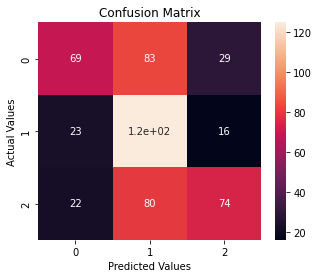


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.61      0.38      0.47       181
         1.0       0.43      0.76      0.55       164
         2.0       0.62      0.42      0.50       176

    accuracy                           0.51       521
   macro avg       0.55      0.52      0.51       521
weighted avg       0.56      0.51      0.51       521

>> k-fold cross-validation

---- Model Analysis ----
Accuracy (train) for GNB: 51.4% 

---- Confusion Matrix ----
         glass  plastic  paper
glass       69       83     29
plastic     23      125     16
paper       22       80     74


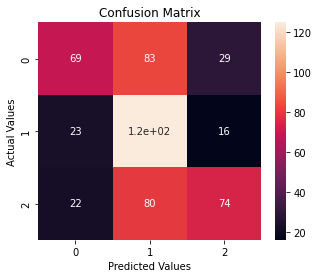


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.61      0.38      0.47       181
         1.0       0.43      0.76      0.55       164
         2.0       0.62      0.42      0.50       176

    accuracy                           0.51       521
   macro avg       0.55      0.52      0.51       521
weighted avg       0.56      0.51      0.51       521



In [14]:
model = GaussianNB()

model_train(model, 'GNB', X_train, y_train, X_test, y_test)

gaussian_nb_params = {
    'var_smoothing': np.logspace(0,-9, num=100),
}

hyper_gaussian_parameters = hyperparameters(model, gaussian_nb_params , X_train, y_train)
model.set_params(**hyper_gaussian_parameters)
model_train(model,'GNB', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X, y)
model_train(kfmodel, 'GNB', X_train, y_train, X_test, y_test)

## SVM


---- Model Analysis ----
Accuracy (train) for SVM: 82.5% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      132       33     16
plastic      8      148      8
paper       14       12    150


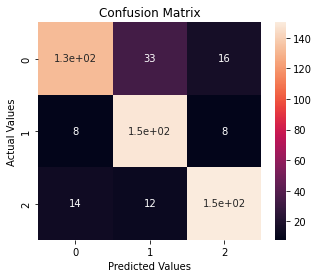


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79       181
         1.0       0.77      0.90      0.83       164
         2.0       0.86      0.85      0.86       176

    accuracy                           0.83       521
   macro avg       0.83      0.83      0.82       521
weighted avg       0.83      0.83      0.82       521

>> k-fold cross-validation

---- Model Analysis ----
Accuracy (train) for SVM: 82.5% 

---- Confusion Matrix ----
         glass  plastic  paper
glass      132       33     16
plastic      8      148      8
paper       14       12    150


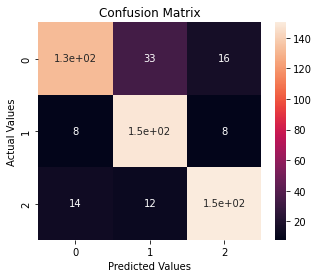


---- Classification Report ----
              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79       181
         1.0       0.77      0.90      0.83       164
         2.0       0.86      0.85      0.86       176

    accuracy                           0.83       521
   macro avg       0.83      0.83      0.82       521
weighted avg       0.83      0.83      0.82       521



In [23]:
model = SVC()

model_train(model, 'SVM', X_train, y_train, X_test, y_test)

# svm_parameters = [{'C': [0.01, 0.1, 1, 10, 50, 100, 1000], 
#               'gamma': [0.001, 0.01, 0.03, 0.1, 0.3, 1],
#               'kernel': ['rbf']}]
# best_svm_params = hyperparameters(model, svm_parameters , X_train, y_train)

# model.set_params(**best_svm_params)
# model_train(model,'SVM', X_train, y_train, X_test, y_test)

kfmodel = kfold(model, 5, X_train, y_train)
model_train(kfmodel, 'SVM', X_train, y_train, X_test, y_test)